 # Clustering

In [3]:
from utils.dataloader import Assistments
from utils.transforms import *
from utils.features import *
from cluster_methods import *

import random
import collections
import warnings

from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score

from tqdm.notebook import tqdm

## Load and prepare dataset

In [4]:
# Load dataset
PATH = 'assistments_2017.csv'

assistments = Assistments(PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'assistments_2017.csv'

In [ ]:
assistments.data.head(5)

In [ ]:
assistments.raw_data.head(5)

In [5]:
# Apply data transforms/features
steps = [
    StudentFeatures(),
    AggStudentFeatures(),
    AvgCorrectFeatures(),
    LastActionStudentFeatures(),
]

assistments.apply(steps)

Applying 4 steps:
Step 1/4: <class 'utils.features.StudentFeatures'>
Step 2/4: <class 'utils.features.AggStudentFeatures'>
Step 3/4: <class 'utils.features.AvgCorrectFeatures'>
Step 4/4: <class 'utils.features.LastActionStudentFeatures'>


In [6]:
assistments.hide_feature('InferredGender')
assistments.apply([Standardize(),])

Applying 1 steps:
Step 1/1: <class 'utils.transforms.Standardize'>


In [7]:
assistments.data.head()

MCAS   AveKnow  AveCarelessness  AveCorrect  NumActions  \
studentId                                                                
8          1.356135  1.151168         1.171496    0.679356    1.061976   
35         0.459861  0.353889         0.754436   -0.206223    0.914180   
39        -0.599371  0.571376         0.641390    0.429968   -0.434753   
64         0.052464 -0.443173        -0.278365   -0.593773    1.913563   
77         0.867258 -0.164357        -0.349412    0.079146   -0.671696   

           AveResBored  AveResEngcon  AveResConf  AveResFrust  AveResOfftask  \
studentId                                                                      
8            -1.202578      1.027182    0.270809    -0.330350      -0.662280   
35           -0.757904     -0.039249   -0.975274     0.760078      -0.710513   
39            0.844152     -0.847127    0.283953     0.329267       0.277879   
64           -1.511085      0.694407   -0.543580     0.087854      -1.247583   
77            0.435344     -0.459371   -1.138536     0.036002       0.456141   

           ...  AveResponseIsFillIn  AveHelpAccessUnder2Sec  \
studentId  ...                                                
8          ...             1.577477                0.719558   
35         ...             1.845856                1.051601   
39         ...             0.601337               -0.813291   
64         ...             2.749099                1.155077   
77         ...             2.195588               -0.361045   

           AveTimeGreater10SecAndNextActionRight  AveTimeOver80  \
studentId                                                         
8                                       0.074827      -0.845574   
35                                     -0.392280      -0.516819   
39                                      0.630564       0.536332   
64                                     -1.005508      -1.266012   
77                                      0.418415       0.688361   

           AveCorrectOriginal  AveCorrectScaffold  hintCount  attemptCount  \
studentId                                                                    
8                    0.844278            0.587771   0.300285      1.298198   
35                  -0.200998            1.077974   1.501925      3.427572   
39                  -0.015079           -0.040367  -0.386366     -0.607031   
64                  -0.318216            0.358784   0.300285     -0.046670   
77                   0.399486            0.235242   0.471948      0.177475   

           totalFrPastWrongCount  totalFrAttempted  
studentId                                           
8                      -0.404869          1.673580  
35                     -0.085523          1.063731  
39                     -0.245196         -0.086926  
64                      0.553170          1.880698  
77                     -0.724215         -0.656502  

[5 rows x 27 columns]

In [8]:
assistments.data.describe()

MCAS       AveKnow  AveCarelessness    AveCorrect  \
count  1.376000e+03  1.376000e+03     1.376000e+03  1.376000e+03   
mean  -2.349592e-16 -3.158054e-18     7.709434e-17  3.911600e-16   
std    1.000364e+00  1.000364e+00     1.000364e+00  1.000364e+00   
min   -1.984521e+00 -1.395309e+00    -1.789343e+00 -1.937840e+00   
25%   -7.623297e-01 -7.367605e-01    -6.963987e-01 -7.564696e-01   
50%   -2.901519e-02 -2.981829e-01    -2.694654e-01 -1.955256e-01   
75%    7.857788e-01  5.322035e-01     5.466436e-01  5.752207e-01   
max    2.089449e+00  4.431056e+00     4.934547e+00  4.494475e+00   

         NumActions   AveResBored  AveResEngcon    AveResConf   AveResFrust  \
count  1.376000e+03  1.376000e+03  1.376000e+03  1.376000e+03  1.376000e+03   
mean  -1.937242e-16 -5.422019e-17  2.162353e-16  1.617327e-16 -3.897278e-16   
std    1.000364e+00  1.000364e+00  1.000364e+00  1.000364e+00  1.000364e+00   
min   -1.269918e+00 -2.360594e+00 -3.959845e+00 -2.736820e+00 -2.314918e+00   
25%   -7.397292e-01 -7.761156e-01 -6.061728e-01 -6.811419e-01 -6.220329e-01   
50%   -2.634972e-01 -3.446547e-02  7.977922e-02 -7.064666e-02 -8.255779e-02   
75%    4.221127e-01  6.835602e-01  7.030291e-01  6.137214e-01  4.757230e-01   
max    5.756263e+00  3.498639e+00  2.674343e+00  7.180191e+00  4.639589e+00   

       AveResOfftask  ...  AveResponseIsFillIn  AveHelpAccessUnder2Sec  \
count   1.376000e+03  ...         1.376000e+03            1.376000e+03   
mean    4.143972e-16  ...        -2.384075e-15            1.178200e-16   
std     1.000364e+00  ...         1.000364e+00            1.000364e+00   
min    -1.716153e+00  ...        -3.724152e-01           -8.682400e-01   
25%    -7.137512e-01  ...        -3.724152e-01           -8.682400e-01   
50%    -1.991450e-01  ...        -3.724152e-01           -4.060344e-01   
75%     5.138995e-01  ...        -3.724152e-01            5.695089e-01   
max     4.767442e+00  ...         7.984371e+00            4.118524e+00   

       AveTimeGreater10SecAndNextActionRight  AveTimeOver80  \
count                           1.376000e+03   1.376000e+03   
mean                            2.683980e-16  -4.016490e-16   
std                             1.000364e+00   1.000364e+00   
min                            -1.631733e+00  -1.406477e+00   
25%                            -7.937517e-01  -7.621393e-01   
50%                            -1.668680e-01  -2.367271e-01   
75%                             5.607930e-01   5.350139e-01   
max                             4.561144e+00   4.775675e+00   

       AveCorrectOriginal  AveCorrectScaffold     hintCount  attemptCount  \
count        1.376000e+03        1.376000e+03  1.376000e+03  1.376000e+03   
mean         7.045398e-16       -7.218063e-16  1.028570e-15 -1.105947e-15   
std          1.000364e+00        1.000364e+00  1.000364e+00  1.000364e+00   
min         -2.817410e+00       -3.454157e+00 -1.244681e+00 -1.391537e+00   
25%         -7.256327e-01       -6.632658e-01 -5.580291e-01 -6.070312e-01   
50%         -1.281643e-01       -1.294212e-02 -3.863662e-01 -2.708142e-01   
75%          6.924758e-01        6.607987e-01  4.719481e-01  4.016196e-01   
max          3.604598e+00        3.291493e+00  8.196777e+00  8.470825e+00   

       totalFrPastWrongCount  totalFrAttempted  
count           1.376000e+03      1.376000e+03  
mean           -7.935351e-17      5.392973e-16  
std             1.000364e+00      1.000364e+00  
min            -1.362908e+00     -1.473469e+00  
25%            -7.242154e-01     -7.543079e-01  
50%            -2.451958e-01     -2.019923e-01  
75%             3.934969e-01      5.171688e-01  
max             1.013356e+01      6.287717e+00  

[8 rows x 27 columns]

## Correlation with MCAS

In [9]:
corrs = assistments.data.corrwith(assistments.data['MCAS'], method='spearman').sort_values(ascending=False)
corrs

MCAS                                     1.000000
AveCorrect                               0.741454
AveKnow                                  0.698926
AveCorrectOriginal                       0.695274
AveTimeGreater10SecAndNextActionRight    0.641483
AveCarelessness                          0.613749
AveCorrectScaffold                       0.413558
AveFrIsHelpRequest                       0.384829
totalTimeByPercentCorrectForskill        0.290722
AveTimeOver80                            0.283045
AveTimeTaken                             0.272329
AveResOfftask                            0.196541
AveResEngcon                             0.181270
AveResBored                              0.085890
totalFrAttempted                         0.053391
AveTimeGreater5SecPrev2Wrong             0.052791
AveResConf                              -0.043639
AveResponseIsFillIn                     -0.097218
MiddleSchoolId                          -0.106323
NumActions                              -0.185328


<AxesSubplot:>

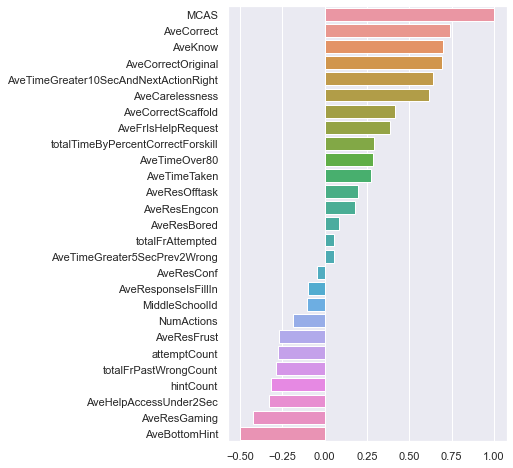

In [10]:
sns.set(rc={"figure.figsize":(5, 8)})
sns.barplot(y=corrs.index, x=corrs.values)

## Prepare dataset for clustering

In [11]:
assistments.hide_feature('MCAS')

In [12]:
assistments.hidden['MCAS'].describe()

MCAS
count  1.376000e+03
mean  -2.349592e-16
std    1.000364e+00
min   -1.984521e+00
25%   -7.623297e-01
50%   -2.901519e-02
75%    7.857788e-01
max    2.089449e+00

## Grid search
Perform grid search on the cluster method and random subsets of features.

In [18]:
class GridSearchLog():
    """
    Log class to save and track gridsearch results.
    """
    
    def __init__(self, data, hparam_names, metric_names):
        """
        Pass clustering dataframe (assistments.data), hyperparameter names (like num_clusters),
        names of metrics.
        
        Will store a logging dataframe in self.log
        """
        self.features = data.data.columns.tolist()
        columns = [ 'feature_' + feature for feature in self.features ]
        self.log = pd.DataFrame(columns=['cluster_method', 'feature_set_id'] + columns + hparam_names + metric_names)
        
    def log_experiment(self, method_name, hparams_dict, metrics_dict, feature_set_id, features):
        """
        Add log results to the dataframe.
        """
        # Generate a feature bitmap for the log entry
        # 1 if its in the selected features and 0 if it is not
        log_entry = { f'feature_{f}': 1 if f in features else 0 for f in self.features }
        
        log_entry['cluster_method'] = method_name
        log_entry['feature_set_id'] = feature_set_id
        
        for k, v in hparams_dict.items():
            log_entry[k] = v
        
        for k, v in metrics_dict.items():
            log_entry[k] = v
            
        self.log = self.log.append(log_entry, ignore_index=True)
        
    def save_as_csv(self, path):
        """ Save the inner dataframe as a CSV to the path. """
        self.log.to_csv(path)
        print(f'Saved log as CSV to {path}')
        
#     def get_top_n(self, method, n = 3, ari = False):
#         if(ari):
#             score_type = 'ARI'
#             log = self.log_ari
#         else:
#             score_type = 'Silhouette score'
#             log = self.log_silhouette
            
#         top_n = sorted(log[method])[-n:][::-1]
#         for score in top_n:
#             res = log[method][score]
#             print('----------------------')
#             print(f'{score_type}: {score}')
#             print(f'Number of clusters k: {list(res)[0]}')
#             print(f'Selected features: {list(res.values())[0]}')
#             print()

Function for grid search

In [19]:
def gridsearch(data, cluster_methods, k_vals = range(2, 8), n_iterations = 30, sample_size = None):
    """
    Perform n_iterations iterations, and during each iteration generate a random subset of features to be
    used (similar to a random forest). 
    
    Within each iteration, for each cluster_method, perform a search over the given k_vals and
    calculate both the silhouette score and several metrics. cluster_methods should be a list of ClusterMethod
    instances.
    
    If sample is not None, sample the dataframe for clustering and subsequent operations
    
    Return a GridSearchLog instance.
    """
    # Randomly sample observations from the data to speed up clustering for grid search
    if sample_size is not None:
        sampled = np.random.choice(np.array(data.data.index), sample_size)
    
    # Instantiate the log
    log = GridSearchLog(data, ['k'], ['silhouette', 'homogeneity', 'completeness', 'V-measure', 'ARI'])
    features = data.data.columns.tolist()
    
    # Iterate over random subsets of features
    for feature_set_id in tqdm(range(n_iterations), desc='Feature Sets: '):
        # Select the subset of features from the data
        features_subset = random.sample(features, random.randint(3, len(features)))
        data_new = data.data[features_subset]
        
        for cluster_method in cluster_methods:
            method_name = str(cluster_method)
            
            for k in tqdm(k_vals, leave=False, desc=f'k search for {method_name}'):
                # Prepare discrete labels for external cluster validaiton metrics later
                mcas = np.array(data.hidden['MCAS'].values.flatten())
                max_mcas = np.max(mcas)
                min_mcas = np.min(mcas)
                bins = np.linspace(min_mcas - 1e-6, max_mcas, k + 1)
                discrete_labels = np.digitize(mcas, bins=bins, right=True)
                
                # Get the cluster labels        
                labels = cluster_method.cluster(data_new[features_subset], n_clusters = k)

                # Join data and labels (ensure indexes match)
                labeled_data = pd.concat([data_new, pd.DataFrame(labels, columns=['cluster'], 
                                                             index = data_new.index)], axis = 1)

                if sample_size is not None:
                    labeled_data = labeled_data.loc[sampled]

                # Split them up again
                sampled_labels = labeled_data['cluster']
                sampled_data = labeled_data.drop(columns = ['cluster'])
                
                # Log metrics
                metrics = {}

                # Calculate the silhouette score
                metrics['silhouette'] = silhouette_score(sampled_data, sampled_labels, n_jobs = -1)
                
                # Calculate the Adjusted Rand index for external cluster validation
                metrics['ARI'] = adjusted_rand_score(discrete_labels, labels)
                metrics['homogeneity'] = homogeneity_score(discrete_labels, labels)
                metrics['completeness'] = completeness_score(discrete_labels, labels)
                metrics['V_measure'] = v_measure_score(discrete_labels, labels)
                
                log.log_experiment(method_name, hparams_dict={'k': k}, metrics_dict=metrics, features=features_subset, feature_set_id=feature_set_id)
                
    return log

Now run the grid search using specified list of clustering methods

In [ ]:
warnings.filterwarnings('ignore')

# Define 3 spectral clustering methods at different n_neighbours
sc5 = SpectralClusterMethod({'n_neighbors': 5}, name_override='Spectral_k5')
sc10 = SpectralClusterMethod({'n_neighbors': 10}, name_override='Spectral_k10')
sc25 = SpectralClusterMethod({'n_neighbors': 25}, name_override='Spectral_k25')

# Perform gridsearch
cluster_methods = [KMeansClusterMethod(), GMMClusterMethod(), HierarchicalClusterMethod(), sc5, sc10, sc25]

res = gridsearch(assistments, cluster_methods, k_vals = range(2,8), n_iterations = 500)

# Save to unique path just so we don't accidentally overwrite
save_path = f'GridSearch_{str(datetime.now().strftime("%d-%m_%H:%M:%S"))}.csv'
res.save_as_csv(save_path)

warnings.filterwarnings('default')

## Cluster plotting code
Plot clusters with PCA and with mean_problem_correctness distributions.

In [53]:
def plot_clusters(data, cluster_labels, MCAS):
    """
    Plot the clusters with hue = cluster labels.
    Plot clusterwise distributions against 
    """    
    # Check for dim reduction
    if data.shape[1] > 2:
        # dimension reduce to 2
        pca = PCATransform(n_components = 2, random_state = 33)
        data = pca.apply(data)
      
    # Start figure
    fig, ax = plt.subplots(3, 1, figsize=(10, 20), gridspec_kw={'height_ratios': [2, 1, 1]})
                
    # Plot 
    sns.set(rc={"figure.figsize":(10, 10)})
    sns.scatterplot(data = data, x = "PC1", y = "PC2", hue = cluster_labels, palette='deep', ax = ax[0])
    
    # add the average correctness column back to the students data frame
    data_mcas = data.join(MCAS)

    # add cluster labels to the students data frame
    data_mcas_labeled = pd.concat([data_mcas, pd.DataFrame(cluster_labels, columns=['cluster_labels'], 
                                                         index = MCAS.index)], axis = 1)

    # plot a histogram of the students based on mean problem correctness 
    sns.histplot(data = data_mcas_labeled, x = 'MCAS', hue = 'cluster_labels', palette='deep', ax = ax[1])
    sns.kdeplot(data = data_mcas_labeled, x = 'MCAS', hue = 'cluster_labels', palette='deep', ax = ax[2])
    
    plt.show()

## Use silhouette plots to select $k$

In [37]:
def silhouette_analysis(cluster_method, data, k_values, sample_size=None):
    """
    Plot the silhouette analysis plots for each k.
    
    Pass cluster_method, a concrete implementation of ClusterMethod (above)
    
    Sample to sample_size before plotting to make things faster, if sample_size != None
    
    Code adapted from sklearn docs:
    'Selecting the number of clusters with silhouette analysis on KMeans clustering'
    """
    # Get sampled data index values which we can use for the analysis
    if sample_size is not None:
        sampled = np.random.choice(np.array(data.index), sample_size)     
    
    for k in k_values:
        # Create subplots
        fig = plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
        # The 1st subplot is the silhouette plot
        n_values = len(data) if sample_size is None else sample_size
        ax.set_xlim([-0.2, 1])
        ax.set_ylim([0, n_values + (k + 1) * 10])
        
        # Get the cluster labels        
        labels = cluster_method.cluster(data, n_clusters = k)
        
        # Join data and labels (ensure indexes match)
        labeled_data = pd.concat([data, pd.DataFrame(labels, columns=['cluster'], 
                                                     index = data.index)], axis = 1)
                
        if sample_size is not None:
            labeled_data = labeled_data.loc[sampled]
            
        # Split them up again :)
        sampled_labels = labeled_data['cluster']
        sampled_data = labeled_data.drop(columns = ['cluster'])
                
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(sampled_data, sampled_labels, n_jobs = -1)
        print(f'For n_clusters = {k} the average silhouette score is {silhouette_avg}')
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(sampled_data, sampled_labels)
        
        y_lower = 10
        
        for i in range(k):
            # Agg silhouette scores for samples belonging to cluster i and sort
            ith_clust_silhouette_values = sample_silhouette_values[sampled_labels == i]
            ith_clust_silhouette_values.sort()
            
            size_clust_i = ith_clust_silhouette_values.shape[0]
            y_upper = y_lower + size_clust_i
            
            color = sns.color_palette("husl", k)[i]
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_clust_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            
            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_clust_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
            
        ax.set_title(f"The silhouette plot for the {k} clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        
        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

We're looking for evenly sized clusters _and_ a high average silhouette score.

For n_clusters = 2 the average silhouette score is 0.27937551189024185
For n_clusters = 3 the average silhouette score is 0.2904441718235052
For n_clusters = 4 the average silhouette score is 0.2192168614002909
For n_clusters = 5 the average silhouette score is 0.20875602236189444
For n_clusters = 6 the average silhouette score is 0.22208926054225914
For n_clusters = 7 the average silhouette score is 0.2144591671897005
For n_clusters = 8 the average silhouette score is 0.19168033783064417
For n_clusters = 9 the average silhouette score is 0.18148942442092258


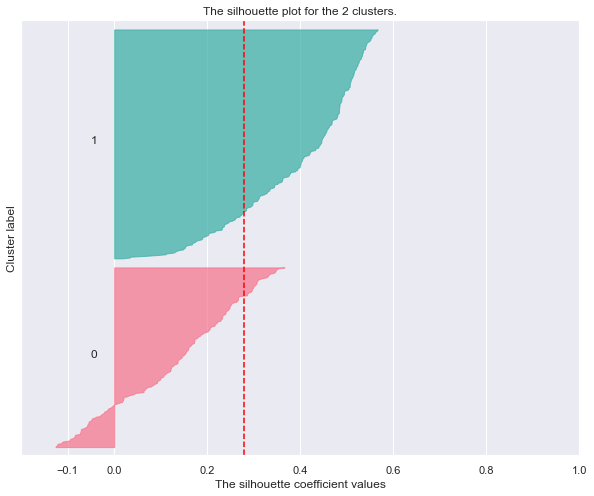

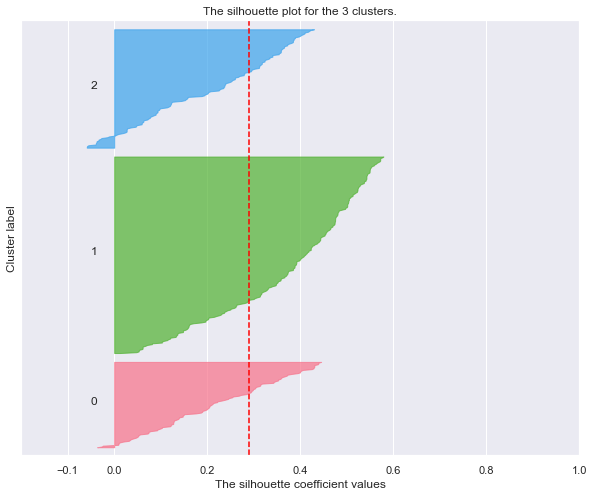

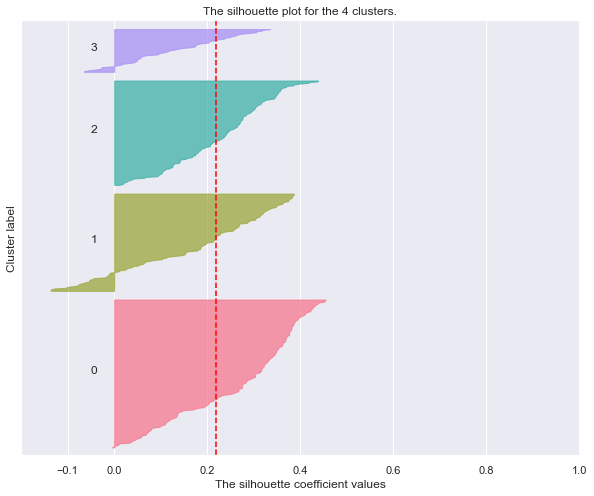

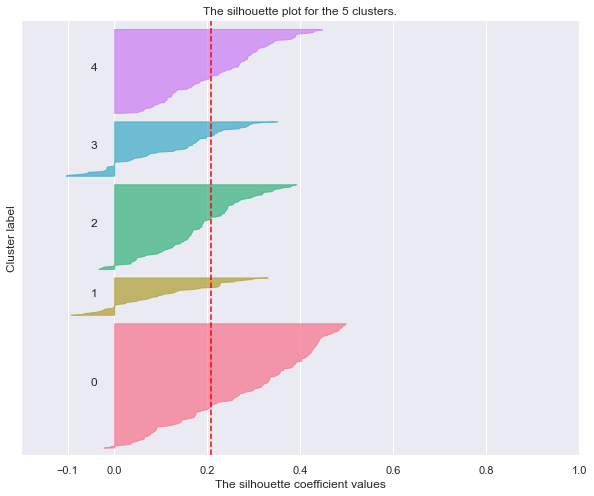

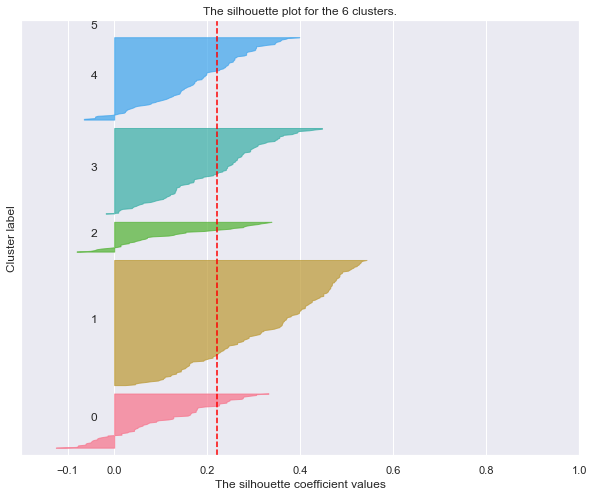

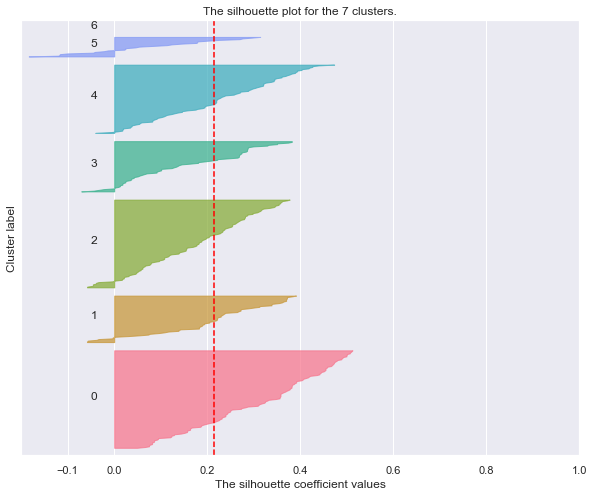

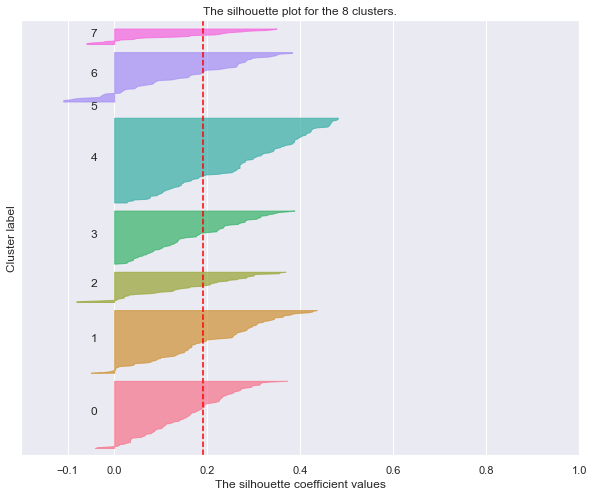

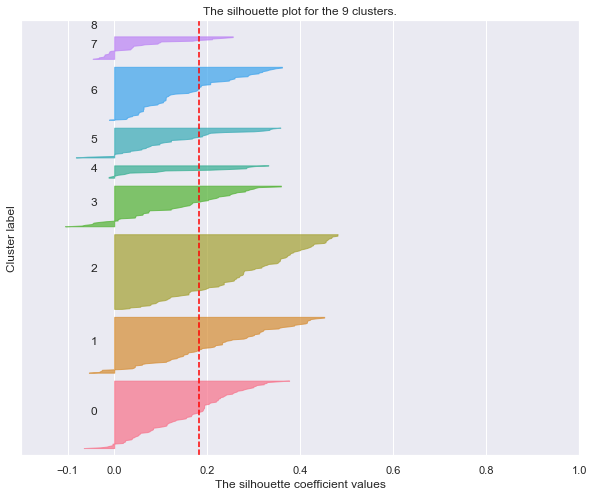

In [53]:
silhouette_analysis(KMeansClusterMethod, assistments.data, range(2, 10), sample_size=500)

Variance explained:  [0.30763598 0.2730721 ]


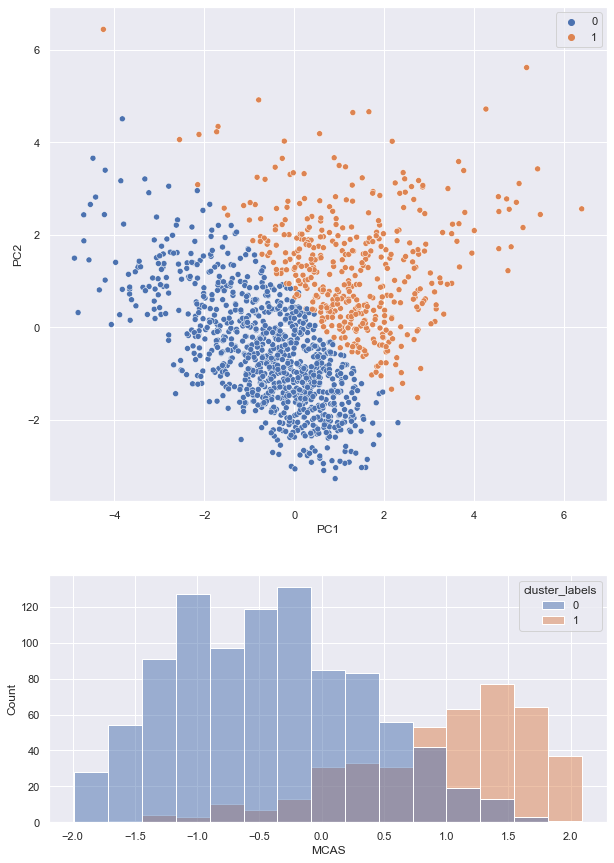

In [267]:
# Plot chosen clustering
labels = KMeansClusterMethod.cluster(assistments.data[chosen_features], n_clusters = chosen_k)
plot_clusters(assistments.data[chosen_features], labels, assistments.hidden['MCAS'])

## Adjusted Rand index for external cluster validation

In [268]:
mcas = np.array(assistments.hidden['MCAS'].values.flatten())
max_mcas = np.max(mcas)
min_mcas = np.min(mcas)

In [269]:
bins = np.linspace(min_mcas - 1e-6, max_mcas, chosen_k + 1)
print(bins)

[-1.98452166  0.0524637   2.08944907]


Variance explained:  [0.39892149 0.19370807]


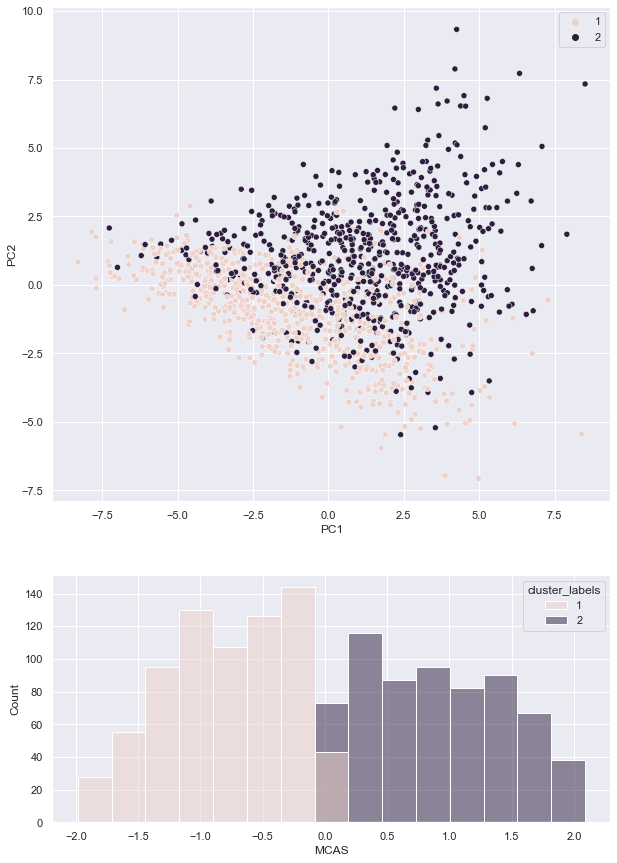

In [270]:
# Get discrete binned labels for mpc
discrete_labels = np.digitize(mcas, bins=bins, right=True)
plot_clusters(assistments.data, discrete_labels, assistments.hidden['MCAS'])

In [271]:
# Calculate ARI

print(f'ARI: {adjusted_rand_score(labels, discrete_labels)}')
print(f'AMI: {adjusted_mutual_info_score(labels, discrete_labels)}')

ARI: 0.2931454212266688
AMI: 0.26412468754154694
